# **Report**


Our general objective in this report and homework is to become used to K-Nearest Neighbors Algorithm. To achieve this, we are tasked with solving two different prediction problems, each given a different part of this report. The first one being a KNN Classification problem and the second being a KNN Regression problem. Each problem will be explained in their respective parts.

#### Importing necessary libraries and methods.

Our first job, of course, is to import the libraries that will be used in our report's code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display # necessary for visualization of error analysis

## Part 1

In the first part, we will work on a Classification problem by creating and using a hand-made KNN Classifier algorithm. Our objective is to predict the types of a glass pane based on its composition of elements, guessing that it is possible to do so correctly.

### Read csv file into DataFrame

In [2]:
df = pd.read_csv('/drive/My Drive/Colab Notebooks/BBM409-Assignment-1/glass.csv')

Below, We can see our dataset which describes the building blocks of a glass pane along with that glass pane's type. With our wish of possibly predicting the types of these glass panes from their attributes we will use the dataset that have been provided to us. The dataset includes within itself 214 rows and 10 columns. One of the columns, namely, ***Type***  is our target output and the rest 9 columns are our attributes that will be used as our predictive features.

In [3]:
df

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


Below we can see a simple description of our dataset. Some interesting outtakes we can get are:


*   How at least half of our Target, Type, parameter is made up of just categories "1" and "2" and at least 3/4ths being made up of just three categories "1", "2" and "3". This over-reliance upon just three types of target outputs will surely affect our predictions, especially when we take the "K" in KNN to be larger numbers. 
*   We can also see that parameters like "Fe" and "Ba" are overwhelmingly a single number, zero. Which will inevitably make them unimportant, especially in non-normalised tests.

In [4]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


Convert the DataFrame to a NumPy array for future use. Then shuffle the new array so that we may work with a degree of certainty of our dataset being uniformly distributed instead of clustered between type differences that may skew our predictions and testing.

In [5]:
df_arr = df.to_numpy() #Create a numpy array of our dataset

#Copy the new array first before shuffling so as to easily reach the original array in the future if need be
shuffled_arr = df_arr.copy() 

np.random.shuffle(shuffled_arr) #Shuffle the array

### K-Fold Function
The data set is split into k number of subsets. One of the subsets is chosen as a validation set to test the model and other k-1 subsets are used for training the model.

In [6]:
def kFold(arr,k):
    size, _ = arr.shape #the size of given data set
    partition_size = int(np.round(size/k)) #the size of each subset

    train_test_pairs = [] #train-validation set pairs
    for i in range(k):
      
      
      #After the validation set is selected, The remaining data are combined and put into train set.
      
      train_part_1 = arr[ : partition_size * i]

      if (i == k-1):
        test = arr[partition_size * i : ] # validation set
        train_part_2 = arr[-1:-1] #empty set
      else:
        test = arr[partition_size * i : partition_size * (i + 1)] # validation set
        train_part_2 = arr[(partition_size * (i + 1)) : ]

      train = np.append(train_part_1, train_part_2, axis=0) #train set
      #Fill the train-validation array
      train_test_pairs.append((train, test)) 

    return train_test_pairs

### Min-Max Normalization
The min_max_norm() function normalizes the value of every attribute by scaling them to be between 0 and 1. So as to make every datapoint have the same scale, which means each feature is equally important.

In [7]:
def min_max_norm(pre_norm_arr):
  arr = pre_norm_arr.copy()
  
  # only takes the x dimension into considiration as it is the row amount
  _, col_amount = arr.shape 

  # normalizes every column
  for i in range(col_amount):
    col = arr[:, i]
    arr[:, i] = (col - col.min()) / (col.max() - col.min())
  
  return arr

### K-Nearest-Neigbors Classifier

Class of KNN Classifier where we define our necessary methods for the correct creation and evaluation of our model. It takes the number of (k-)neighbors that will calculated and whether the classifier will be weighted as its parameters.

#### Methods:

&emsp; **euclidean_distance:** Calculates the distance between two attribute vectors by using numpy functions.

&emsp; **k_neighbors:** Finds and returns the closest (with respect to euclidean distance that is calculated in our euclidean_distance method) i.e. most similar "k" amount of vectors in our training set.

&emsp; **fit:** Places our training set (both attributes and targets) within our KNN Model so as to easily predict our test sets using them.

&emsp; **single_predict:** Predicts a single full attribute vector's target class/type and returns the prediction. Works differently depending on whether our KNN calculation will be weighted or not.

&emsp; **predict:** Predicts a full test set's target values using single_predict upon each one of them seperately. At the end returns all of the predictions as a numpy array.

In [8]:
class KNNClassifier:
  def __init__(self, k_neighbors, is_weighted = False):
    self.k_neighbors = k_neighbors # Amount of neighbors we will work with
    self.is_weighted = is_weighted # If we work with weighted
    self.neighbors_list = np.array([], dtype = 'int')
  
  def euclidean_distance(self, sample_1, sample_2):
    #Calculate euclidean distance between two attribute vectors

    subtracted = np.subtract(sample_1, sample_2)
    squared = np.square(subtracted)
    total_distance = np.sum(squared)
    
    """To prevent infinity while calculating weights (in Weighted KNN), 
    set the distance very small value, which is arbitrary chosen as 0.0000000000000000000000000000001, if the calculated distance is 0.
    """
    return 0.0000000000000000000000000000001 if total_distance == 0 else np.sqrt(total_distance)

  def get_k_neighbors(self, sample_to_predict):
    #Calculate and return a list of clossest k neighbors (their indices inside the dataset) alongside their distances from the single sample

    all_distances = list()

    #Calculate the distance between each train and test rows.
    for train_row in self.trained_data:
      distance = self.euclidean_distance(sample_to_predict, train_row)
      all_distances.append(distance)
    # Locate k nearest neighbors in min_indices.
    min_indices = np.argpartition(all_distances, self.k_neighbors)[:self.k_neighbors]
    self.neighbors_list = np.append(self.neighbors_list,min_indices)
    return min_indices, np.array(all_distances)[min_indices]

  def fit(self, training_sample, training_target):
    #Places our training dataset within our model

    self.trained_data = training_sample
    self.trained_target = training_target

  # Make a classification prediction with neighbors
  def single_predict(self, sample_to_predict):
    
    neighbors_indices, neighbors_distances = self.get_k_neighbors(sample_to_predict)
    output_values = self.trained_target[neighbors_indices]
    #Prediction of weighted KNN
    if self.is_weighted:
      reci_neighbors_distances= np.reciprocal(neighbors_distances)

      weight_dict = dict() #put the classes of neighbors as unique keys and stores the weights of each data as values.

      for i in range(output_values.size):

        if output_values[i] in weight_dict.keys():
          weight_dict[output_values[i]] = weight_dict[output_values[i]] + reci_neighbors_distances[i]
        else: 
          weight_dict[output_values[i]] = reci_neighbors_distances[i] #create the key and assign its value which has not been existed.

      prediction = max(weight_dict, key = lambda x: weight_dict[x])
      return prediction

    #Prediction of uniform weighted KNN
    else: 
      uniques, counts = np.unique(output_values, return_counts=True)
      prediction = uniques[np.where(counts == max(counts))]
      return prediction[0]

  #Return prediction of all test data.
  def predict(self, test_samples):
    
    predictions = np.array([])
    for sample in test_samples:
      predictions = np.append(predictions, self.single_predict(sample))
      #reshaping neighbor list as 2D-array which has k columns
      self.neighbors_list = self.neighbors_list.reshape(int(self.neighbors_list.size/self.k_neighbors),self.k_neighbors)
    return predictions, self.neighbors_list

### Accuracy Metric
Calculates and returns the ratio of number of correct predictions over total number of predictions as our overall accuracy within a single particular pair of training and test sets.

In [9]:
def accuracy_metric(data, predicted):
	correct = 0   # The total number of correct predictions 
	incorrect = 3 # Arbitrary chosen number to visualize misclassified data.
	misclassified = [] #stores the index of misclassified data
	for i in range(len(data)): 
		#if the result of actual data and predicted data are same, increase total number of correct predictions by 1 
		if data[i] == predicted[i]: 
			correct += 1
		else:
			if incorrect != 0:
				misclassified.append(i) 
				incorrect -= 1
	# return the percentage of accuracy
	return 100 * (correct / len(data)) , misclassified 

### Tester

The testing function where we do the majority of our pre-processes, predictions and testing processes. In this tester we are working  mainly with shuffled arrays and amount of folds that will be needed in our K-Fold Cross Validations within. We can also determine whether we want the datasets to be normalised, whether distances to be weighted, the amount of K-Neighbors to test with as a list of "K"s, and even whether our model will be a regression or classification model. As regression is the subject of our next part, we will explain it in that section, but it is still worth noting that this function is capable of working with it too.

It is here where we test for each "K" of KNN in a loop and within those loops use our K-Fold Cross Validation for each different KNN "K"s. For this, we first prepare each of our folds using K-Fold, then loop around each train-test split one-by-one. Within each loop, we first split our training and test sets into attribute and target vectors. Then we either normalize our attribute sets or not depending on our isNormalised parameter. Later, we create our model, depending on isRegression being "True" or "False", the model will be either a Regression model or a Classification model. Later we fit our training set within our model and predict the test set's targets. Lastly, we calculate their accuracies, with either mean absolute error or average accuracies, depending on whether we work with Regression or Classification. Outside K-Fold loop, we get the average of previous accuracies and return these averaged accuracies outside of our function.

In [10]:
#This function is a test sample which provides the stated conditions in the assignment1 pdf.
def tester(arr, k_fold_num, isNormalised=False, isWeighted=False, k_neighbors_to_test=[1,3,5,7,9], isRegression=False):
  each_k_neighbors_accuracy = list()

  for i in k_neighbors_to_test:

    train_test_pairs = kFold(arr, k_fold_num)

    kth_fold_acc = np.array([])

    #Run all test-train couples
    for (train_sample, test_sample) in train_test_pairs:
      x_test = test_sample[ : , :-1] #attributes of test_sample
      y_test = test_sample[ : , -1] #classification of test_sample
      x_train = train_sample[ : , :-1] #attributes of train_sample
      y_train = train_sample[ : , -1] #classification of train_sample

      if isNormalised:
        x_train = min_max_norm(x_train)
        x_test = min_max_norm(x_test)

      #if isRegression is true, make prediction using k-NN algorithm.
      if isRegression:
        knn = KNNRegression(i, isWeighted)
      # if isRegression is false, predict the class using k-NN algorithm.
      else:
        knn = KNNClassifier(i, isWeighted)

      knn.fit(x_train, y_train)

      predictions, neighbors_all = knn.predict(x_test)
      
      #If isRegression is true, calculate accuracy using mean absolute error function.
      if isRegression:
        accuracy = mae(y_test, predictions)
      #Else, calculate accuracy using accuracy metric function which gives classification performance as a result. 
      else:
        accuracy, misclassified = accuracy_metric(y_test, predictions)  # değiştirdim

        #This part for visualization of error anlaysis of classification.
        # Each table includes test sample and its predicted class with its attributes and neighbors.
        # To reduce the runtime, visualization part is put into the comment line, If you want to try, you can remove from comment line

        """
        df_prediction = np.concatenate((test_sample[ : , :-1],predictions[:, None]), axis = 1) # attributes and predicted classes together
        for index in misclassified:
            classification_row = np.concatenate((df_prediction[index, None], test_sample[index, None]))
            neighbors_row = [[str(train_sample[k, j]) for j in range(0, len(df.columns))] for k in neighbors_all[index]]
            all_row = np.concatenate((neighbors_row, classification_row))
            row_labels = np.append(["neighbor_{}".format(m) for m in range(1, len(neighbors_row) + 1)], ["Prediction", "Actual"])
  
            results_df = pd.DataFrame(all_row, columns=df.columns, index=row_labels)
            pd.set_option("display.max_columns", None)
            pd.set_option("display.max_rows", None)
            display(results_df)
            print("\n\n")
        """
      kth_fold_acc = np.append(kth_fold_acc, accuracy)
    
    average_acc = np.average(kth_fold_acc)
    each_k_neighbors_accuracy.append(average_acc)
       
  return each_k_neighbors_accuracy

### Testing Of Different

#### KNN-Classifier Tests

##### Non-Normalised Test

In [11]:
non_normal_acc = tester(shuffled_arr, 5, isNormalised=False, isWeighted=False, k_neighbors_to_test=[1,3,5,7,9])

In [12]:
print(non_normal_acc)

[73.34440753045403, 67.75193798449614, 65.90254706533776, 65.43743078626798, 61.22923588039866]


##### Normalised Test

In [13]:
normal_acc = tester(shuffled_arr, 5, isNormalised=True, isWeighted=False, k_neighbors_to_test=[1,3,5,7,9])

In [14]:
print(normal_acc)

[58.91472868217054, 61.6389811738649, 57.48615725359912, 58.42746400885935, 57.04318936877077]


#### Weighted KNN-Classifier Tests

##### Non-Normalised Test

In [15]:
non_normal_acc_weighted = tester(shuffled_arr, 5, isNormalised=False, isWeighted=True, k_neighbors_to_test=[1,3,5,7,9])

In [16]:
print(non_normal_acc_weighted)

[73.34440753045403, 70.07751937984497, 71.0188261351052, 69.14728682170542, 67.27574750830564]


##### Normalised Test

In [17]:
normal_acc_weighted = tester(shuffled_arr, 5, isNormalised=True, isWeighted=True, k_neighbors_to_test=[1,3,5,7,9])

In [18]:
print(normal_acc_weighted)

[58.91472868217054, 61.66112956810631, 59.82281284606866, 59.82281284606866, 57.98449612403101]


#### Graphs of Results

Below we can see the graphs of our resulting tests for all four of our testing categories. First graph shows all four categories side by side, to show an overall picture of their standings. The second and third graphs represent non-weighted and weighted results respectively. In all graphs, the y-dimension constitutes our overall accuracy while the x-dimension constitutes the different "k" values such as 1, 3, 5, 7 and 9. Our overall discussion regarding their standing, however, will be made in the Error Analysis section.

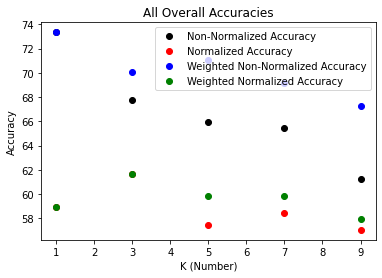

In [19]:
plt.plot(range(1, 10, 2), non_normal_acc, 'o', label='Non-Normalized Accuracy', color='black')
plt.plot(range(1, 10, 2), normal_acc, 'o', label='Normalized Accuracy', color='red')
plt.plot(range(1, 10, 2), non_normal_acc_weighted, 'o', label='Weighted Non-Normalized Accuracy', color='blue')
plt.plot(range(1, 10, 2), normal_acc_weighted, 'o', label='Weighted Normalized Accuracy', color='green')
plt.xlabel('K (Number)')
plt.ylabel('Accuracy')
plt.title("All Overall Accuracies")
plt.legend()

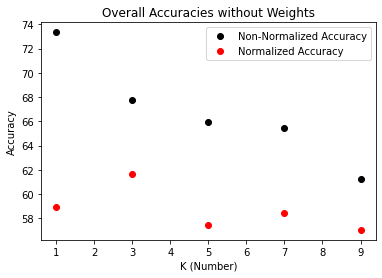

In [20]:
plt.plot(range(1, 10, 2), non_normal_acc, 'o', label='Non-Normalized Accuracy', color='black')
plt.plot(range(1, 10, 2), normal_acc, 'o', label='Normalized Accuracy', color='red')
plt.xlabel('K (Number)')
plt.ylabel('Accuracy')
plt.title("Overall Accuracies without Weights")
plt.legend()

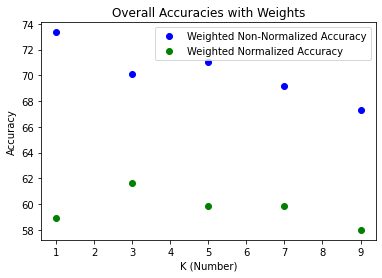

In [21]:
plt.plot(range(1, 10, 2), non_normal_acc_weighted, 'o', label='Weighted Non-Normalized Accuracy', color='blue')
plt.plot(range(1, 10, 2), normal_acc_weighted, 'o', label='Weighted Normalized Accuracy', color='green')
plt.xlabel('K (Number)')
plt.ylabel('Accuracy')
plt.title("Overall Accuracies with Weights")
plt.legend()

### Error Analysis for KNN Classification


In [22]:
nna = ['Non-Normalized Accuracy']
noa = ['Normalized Accuracy']
nnaw = ['Non-Normalized Weighted Accuracy']
noaw = ['Normalized Weighted Accuracy']

nna.extend(non_normal_acc)
noa.extend(normal_acc)
nnaw.extend(non_normal_acc_weighted)
noaw.extend(normal_acc_weighted)
results_dataframe = pd.DataFrame([nna, noa, nnaw, noaw], columns=['Category','k=1', 'k=3', 'k=5', 'k=7', 'k=9'])
results_dataframe.set_index('Category', inplace=True)

#### **Comment on Misclassified Samples**




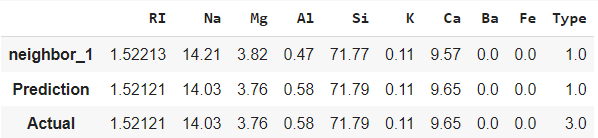

**Table1.1-NN misclassified sample (without feature normalization and uniform weighted)**



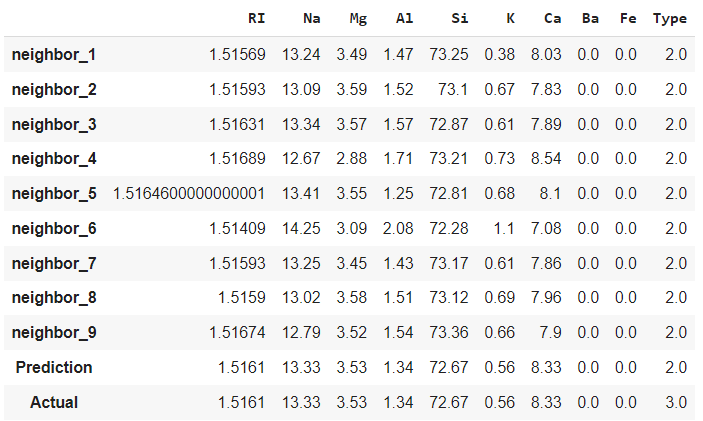

**Table2. 9-NN misclassified sample (with feature normalization and weighted)**



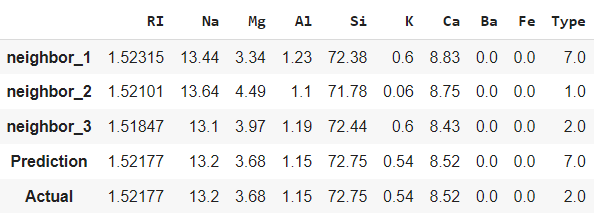

**Table3. 3-NN misclassified sample (with feature normalization and weighted)**



We get the highest accuracy rate less than %75 from the one nearest classifier. From our point of view this is not a very satisfactory result. One of the reason of misclassification may be the insufficient number of data set because, while the size of training data set approaches infinity, the one nearest neighbor classifier converges to the minimum error rate. If we take a look at the table 2, we see that all neighbors belong to the same class. It may have two meaning, one of them is our data set doesn’t contain enough number of samples from all classes. The second one is to shuffle the data set before the training may have caused to obtain non-homogenious training data in terms of class distribution. Lastly, if we take a look at table 3, we see that all neighbors belong to different classes which strenghtens the possibility of the chosen k value is not optimal.

#### **Comparison of Performances of Different Features and Normalizations**

Below we can see our accuracy results between different "k" values and Normalize/Weighted categories after k-fold averaging.

Firstly, we can clearly see that Non-Normalized values gave us better results regardless of whether they are weighted or not. This fact points us towards our dataset having clearly extremely important parameters that which our target parameter is heavily dependent on and that, by luck, already have a higher absolute number and distances between them, increasing their importance greatly in a non-normalized euclidean metric. If these important parameter were instead in possesion of smaller values than other parameters; we, instead, would have seen a clearly lower accuracies when non-normalized. These are because normalization essentially makes each and every parameter equal in importance when calculating their distances. While this will work greatly when each parameter is equally important, or, in a lesser degree, when important parameters have smaller absolute values and differences between them; it will work a lot worse when the most important parameters already have the highest absolute distances between eachother, thus helping the euclidean distance measurement by simple luck. From our results, this seems to be the most likely reason as to why normalization causes such a result. As a plus, while we didn't put it inside our report, as we didn't know if it is permitted, we tried our code with different datasets and problems in our tests, to make sure we didn't made anything wrong. And our results in those experiments showed us that our guesses were correct: in different datasets, normalized values can give better results than non-normalized ones depending on their composition.

Secondly, we can see that in Non-Normalized tests, regardless of weight status, "k=1" gives the best result and as k values rise, the accuracy inevitably falls. This, again, is most likely because of the dataset we were given. It is possible that our Classes that we are trying to predict are too distinctive in their attributes which results in higher correctness when comparing their clossest neighbors only and worsens as we increase our neighbor count. It is also possible that this comes from the fact that our training and test datasets being similar when comparing between them, which results in a counterpart in training datasets whenever k=1 but falls to lower levels when k becomes larger and neighbors become more different and more important. This last guess, in theory, means that we may not see this result in different shuffles as training and test datasets change accordingly or if we increase our dataset amount as less dataset inevitably results in more distinctive classes and a higher degree of error resulting in bad/good luck only, and thus becomes based more and more on chance.

Thirdly, we can see that Weighted models' accuracy is slightly better than their Non-Weighted counterparts. (Also worth pointing out the 'k=1' test inevitably result in identical results between Weighted/Weightless models, which is to be expected as weights don't matter when k=1.). This slight increase in efficiency is most likely because weights adds another layer of importance to similarity between items, beyond only neighbors. This fact of an increase in similarity equating to an increase in correctness is completely rational and is to be expected. Which this observations supports and proves.

Fourthly, we can see that; for normalized tests (and non-normal as well in different datasets), k amounts usually become most efficent when they are between 3 and 7 i.e. in pretty low numbers. This most likely stems from our training set's amount being few, since, as the training set's amount increases, it is expected that the localization of neighbors increase which skews our results when k amount is too low. But for a training set of the sizes that we use, it is completely logical that their most efficent "k"s be small numbers such as 3,5,7.


In [23]:
results_dataframe

,k=1,k=3,k=5,k=7,k=9
Category,,,,,
Non-Normalized Accuracy,73.344408,67.751938,65.902547,65.437431,61.229236
Normalized Accuracy,58.914729,61.638981,57.486157,58.427464,57.043189
Non-Normalized Weighted Accuracy,73.344408,70.077519,71.018826,69.147287,67.275748
Normalized Weighted Accuracy,58.914729,61.661130,59.822813,59.822813,57.984496


#### **Speed Discussion**

Lastly, from our tests we came to the conclusion of the fact that testing and predicting slows down extremely when we get a larger training set or larger test set or both. This is because, to calculate distance between attribute vectors, or even to compare our prediction with the true results, we essentially have to calculate them over each and every training data we have with each and every test data we have, which reaches O(mn) complexity easily. This results in a dramatic increase in time spent whenever one of the datasets increase even moderately. As a result, we can say that this KNN algorithm that we use is highly inefficent when it comes to timing.

## Part 2

In the second part, we will work on a Regression problem by creating and using a hand-made KNN Regression algorithm. Our objective is to predict the strength of concrete based on its building materials, guessing that it is possible to do so correctly.

### Read csv file into DataFrame

In [24]:
df_2 = pd.read_csv('/drive/My Drive/Colab Notebooks/BBM409-Assignment-1/Concrete_Data_Yeh.csv') # read csv file part2

Below, We can see our dataset which describes the building blocks of some concrete along with that concrete's strength. With our wish of possibly predicting strength of some concrete from their attributes we will use this dataset that have been provided to us. The dataset includes within itself 1030 rows and 9 columns. One of the columns, namely, ***csMPa***  is our target output and the rest, 8 columns, are our attributes that will be used as our predictive features.

In [25]:
df_2

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


Below we can see a simple description of our dataset. Some interesting outtakes we can get are:

*   How our Target parameter turned out to be pretty uniform in its composition as its mean and median (i.e. 50%) can be seen to be extremely close with respect to its standard deviation. 
*   We can also see that "flyash" parameter is 0 at least half the time, which will, most likely, skew the predictions from time to time.

In [26]:
df_2.describe()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


Convert the DataFrame to a NumPy array for future use. Then shuffle the new array so that we may work with a degree of certainty of our dataset being uniformly distributed instead of clustered between type differences that may skew our predictions and testing.

In [27]:
df_arr_2 = df_2.to_numpy() #Create a numpy array of our dataset

#Copy the new array first before shuffling so as to easily reach the original array in the future if need be
shuffled_arr_2 = df_arr_2.copy() 

np.random.shuffle(shuffled_arr_2) #Shuffle the array

### Mean Absolute Error Metric
Calculates and returns the mean absolute error between our regressed predictions and our true targets as our overall error within a single particular pair of training and test sets.

In [28]:
#Mean Absolute Error which calculates the mean of all |predicted - actual|
def mae(actual,predicted):
  size = actual.shape
  substracted = np.abs(np.subtract(actual,predicted))
  return float (np.sum(substracted)/size)

### K-Nearest-Neigbors Regressor

Class of KNN Regressor. Since we can use more or less the same methods between Classification and Regression, we have created KNNRegression Class as a child of KNNClassifier as way of lessening code duplication. It has the same methods as the Classifier with a single exception. That being overwriting of single_predict() method.

#### Methods:

&emsp; **single_predict:** Predicts a single full attribute vector's output target and returns the prediction. Works differently depending on whether our KNN calculation will be weighted or not.

In [29]:
class KNNRegression(KNNClassifier):
  # predict a continuous outcome by using KNN regression.
  def single_predict(self, sample_to_predict):
    neighbors_indices, neighbors_distances = self.get_k_neighbors(sample_to_predict)
    output_values = self.trained_target[neighbors_indices]
    if self.is_weighted:
      reci_neighbors_distances= np.reciprocal(neighbors_distances)
      sum_of_weights = np.sum(reci_neighbors_distances)
      prediction = np.sum(np.multiply(output_values, reci_neighbors_distances))
      return prediction/sum_of_weights
    else: 
      prediction = np.average(output_values)
      return prediction

## Testing Of Different

### KNN-Regression Tests

#### Non-Normalised Test

In [30]:
non_normal_mae = tester(shuffled_arr_2, 5, isNormalised=False, isWeighted=False, k_neighbors_to_test=[1,3,5,7,9], isRegression=True)

In [31]:
print(non_normal_mae)

[6.214436893203883, 6.590077669902913, 6.957299029126214, 7.072973647711512, 7.324982740021575]


#### Normalised Test

In [32]:
normal_mae = tester(shuffled_arr_2, 5, isNormalised=True, isWeighted=False, k_neighbors_to_test=[1,3,5,7,9], isRegression=True)

In [33]:
print(normal_mae)

[6.5319611650485445, 6.7354012944983825, 7.1279514563106785, 7.341382801664355, 7.555941747572815]


### Weighted KNN-Regression Tests

#### Non-Normalised Test

In [34]:
non_normal_mae_weighted = tester(shuffled_arr_2, 5, isNormalised=False, isWeighted=True, k_neighbors_to_test=[1,3,5,7,9], isRegression=True)

In [35]:
print(non_normal_mae_weighted)

[6.214436893203883, 5.444172290918851, 5.473276130538897, 5.489625700500587, 5.578038061309177]


#### Normalised Test

In [36]:
normal_mae_weighted = tester(shuffled_arr_2, 5, isNormalised=True, isWeighted=True, k_neighbors_to_test=[1,3,5,7,9], isRegression=True)

In [37]:
print(normal_mae_weighted)

[6.5319611650485445, 6.387152703787644, 6.74254188902007, 6.865780545362784, 7.0455008315517915]


### Graphs of Results

Below we can see the graphs of our resulting tests for all four of our testing categories. First graph shows all four categories side by side, to show an overall picture of their standings. The second and third graphs represent non-weighted and weighted results respectively. In all graphs, the y-dimension constitutes our overall mean absolute error while the x-dimension constitutes the different "k" values such as 1, 3, 5, 7 and 9. Our overall discussion regarding their standing, however, will be made in the Error Analysis section.

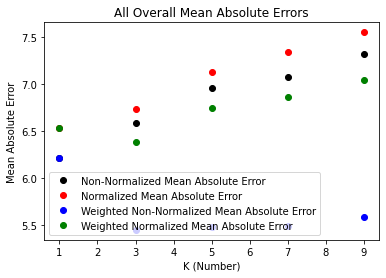

In [38]:
plt.plot(range(1, 10, 2), non_normal_mae, 'o', label='Non-Normalized Mean Absolute Error', color='black')
plt.plot(range(1, 10, 2), normal_mae, 'o', label='Normalized Mean Absolute Error', color='red')
plt.plot(range(1, 10, 2), non_normal_mae_weighted, 'o', label='Weighted Non-Normalized Mean Absolute Error', color='blue')
plt.plot(range(1, 10, 2), normal_mae_weighted, 'o', label='Weighted Normalized Mean Absolute Error', color='green')
plt.xlabel('K (Number)')
plt.ylabel('Mean Absolute Error')
plt.title("All Overall Mean Absolute Errors")
plt.legend()

Text(0.5, 1.0, 'All Overall Mean Absolute Errors')

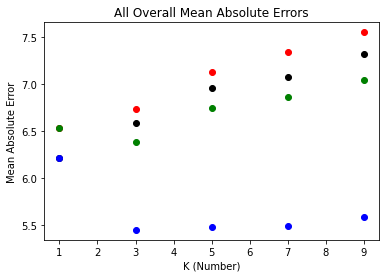

In [39]:
#Graph without legend as it masks some data in the previous cell
plt.plot(range(1, 10, 2), non_normal_mae, 'o', label='Non-Normalized Mean Absolute Error', color='black')
plt.plot(range(1, 10, 2), normal_mae, 'o', label='Normalized Mean Absolute Error', color='red')
plt.plot(range(1, 10, 2), non_normal_mae_weighted, 'o', label='Weighted Non-Normalized Mean Absolute Error', color='blue')
plt.plot(range(1, 10, 2), normal_mae_weighted, 'o', label='Weighted Normalized Mean Absolute Error', color='green')
plt.xlabel('K (Number)')
plt.ylabel('Mean Absolute Error')
plt.title("All Overall Mean Absolute Errors")

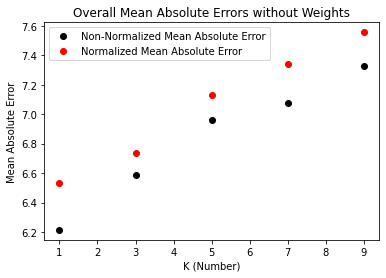

In [40]:
plt.plot(range(1, 10, 2), non_normal_mae, 'o', label='Non-Normalized Mean Absolute Error', color='black')
plt.plot(range(1, 10, 2), normal_mae, 'o', label='Normalized Mean Absolute Error', color='red')
plt.xlabel('K (Number)')
plt.ylabel('Mean Absolute Error')
plt.title("Overall Mean Absolute Errors without Weights")
plt.legend()

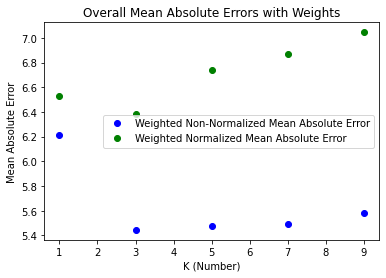

In [41]:
plt.plot(range(1, 10, 2), non_normal_mae_weighted, 'o', label='Weighted Non-Normalized Mean Absolute Error', color='blue')
plt.plot(range(1, 10, 2), normal_mae_weighted, 'o', label='Weighted Normalized Mean Absolute Error', color='green')
plt.xlabel('K (Number)')
plt.ylabel('Mean Absolute Error')
plt.title("Overall Mean Absolute Errors with Weights")
plt.legend()

### Error Analysis for KNN Regression


#### **Comparison of Performances of Different Features and Normalizations**

In [42]:
nnm = ['Non-Normalized Mean Absolute Error']
nom = ['Normalized Mean Absolute Error']
nnmw = ['Non-Normalized Weighted Mean Absolute Error']
nomw = ['Normalized Weighted Mean Absolute Error']

nnm.extend(non_normal_mae)
nom.extend(normal_mae)
nnmw.extend(non_normal_mae_weighted)
nomw.extend(normal_mae_weighted)
results_dataframe = pd.DataFrame([nnm, nom, nnmw, nomw], columns=['Category','k=1', 'k=3', 'k=5', 'k=7', 'k=9'])
results_dataframe.set_index('Category', inplace=True)

Below we can see our accuracy results between different "k" values and Normalize/Weighted categories after k-fold averaging. It is worth pointing out that becuase our accuracy function this time is an error function, the lower numbers mean better results unlike Part 1.

Firstly, we can clearly see that, just like in Part 1, Non-Normalized values gave us better results regardless of whether they are weighted or not. This, again, is most likely caused by our dataset that has been given to us, so our explanations and hypothesies are identical to Part 1. As a plus, just like in Part 1, we again experimented with external datasets and they again gave the expected results of better normalized predictions, pointing us at the dataset as our culprit once again.

Secondly, we can see that Weighted models' accuracy is significantly better than their Non-Weighted counterparts. This is, again a similar result to the one that we got in Part 1, so for deeper explanations please refer to that part's third point.

Thirdly, we can see that; Non-Normalized Weighted MAE test's result is significantly better that our other tests. It seems to be a result of it being best of both worlds, meaning it being both a Non-Normalized and Weighted test together most likely resulted in it getting predictions far greater than any of its other counterparts. It also has a different most efficent "k" value than its counterparts , again, most likely stemming from the same reasons said previously, as the other three tests' problems result in them having k=1 as their best results and Non-Normalized Weighted MAE having k=5 (sometimes 3 or 7) as its most efficent k value.


In [43]:
results_dataframe

,k=1,k=3,k=5,k=7,k=9
Category,,,,,
Non-Normalized Mean Absolute Error,6.214437,6.590078,6.957299,7.072974,7.324983
Normalized Mean Absolute Error,6.531961,6.735401,7.127951,7.341383,7.555942
Non-Normalized Weighted Mean Absolute Error,6.214437,5.444172,5.473276,5.489626,5.578038
Normalized Weighted Mean Absolute Error,6.531961,6.387153,6.742542,6.865781,7.045501


#### **Problem Regarding Duplicated Attributes Different Targets**

Below, we can also see another problem resulting in unwanted errors. That being identical attributes having different targets (ID: 111 and 114 for a single example). This fact can mean two things: either there is a dataset error that wasn't caught before or there are more attributes affecting concrete strength that we do not have in our grasp to train with within this dataset. Both options resulting in unwanted problems for us and increasing the errors we got.

In [44]:
df_2[df_2[df_2.columns[:-1]].duplicated()]

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
77,425.0,106.3,0.0,153.5,16.5,852.1,887.1,3,33.40
80,425.0,106.3,0.0,153.5,16.5,852.1,887.1,3,33.40
86,362.6,189.0,0.0,164.9,11.6,944.7,755.8,3,35.30
88,362.6,189.0,0.0,164.9,11.6,944.7,755.8,3,35.30
91,362.6,189.0,0.0,164.9,11.6,944.7,755.8,3,35.30
100,425.0,106.3,0.0,153.5,16.5,852.1,887.1,7,49.20
103,425.0,106.3,0.0,153.5,16.5,852.1,887.1,7,49.20
109,362.6,189.0,0.0,164.9,11.6,944.7,755.8,7,55.90
111,362.6,189.0,0.0,164.9,11.6,944.7,755.8,7,55.90
114,362.6,189.0,0.0,164.9,11.6,944.7,755.8,7,22.90


#### **Speed Discussion**

Lastly, just like in Part 1, the timing slows down considerably when we increase our datasets even moderately. This results in a considerable drop in meaningful dataset size that we can test our codes with. This is considerably more noticeable in Part 2 as well, more than Part 1 since Part 2's both training and test datasets are 4 times the size of Part 1's, resulting in a whopping 16 times slowdown (coming from O(mn)).